In [1]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
import pandas as pd
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'results'))
OUTPUT_PATH = os.path.abspath(os.path.join(os.getcwd(), 'figures'))

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# Adapted from https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
sns.set(font='Helvetica',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': True,
 'axes.axisbelow': True,
 'grid.color': 'lightgrey',
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":14,
                                "axes.titlesize":16,
                                "axes.labelsize":13})

In [3]:
def parse_json(path):
    data = {}
    for f in os.listdir(path):
        lambda_no = 1
        has_multiple_lambda = False
        matches_multiple_lambda = re.search(r"(producer|consumer)_(\d+)_(\d+)_(\d+).json", f)
        if matches_multiple_lambda:
            lambda_no = int(matches_multiple_lambda.group(4))
            has_multiple_lambda = True
            matches = matches_multiple_lambda
        else:
            matches = re.search(r"(producer|consumer)_(\d+)_(\d+).json", f)
        if matches:
            run_type, file_size, run = matches.group(1), int(matches.group(2)), int(matches.group(3))
            if run_type not in data:
                data[run_type] = {}
            if file_size not in data[run_type]:
                data[run_type][file_size] = {}
            if has_multiple_lambda and run not in data[run_type][file_size]:
                data[run_type][file_size][run] = {}
            with open(os.path.join(path, f)) as file_p:
                json_data = json.load(file_p)
                if has_multiple_lambda:
                    data[run_type][file_size][run][lambda_no] = json_data
                else:
                    data[run_type][file_size][run] = json_data
    return data

def calc_deltas(data):
    deltas = {}
    for file_size, runs in data['consumer'].items():
        deltas[file_size] = {}
        for run_number, run_data in runs.items():
            if 'finishedTime' in run_data: # single lambda
                if int(np.log10(run_data['finishedTime'])) == 15:
                    # Convert to ms
                    run_data['finishedTime'] /= 1000
                    data['producer'][file_size][run_number]['uploadTime'] /= 1000
                if run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime'] < 0.1:
                    deltas[file_size][run_number] = 0.1
                else:
                    deltas[file_size][run_number] = run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime']
                
            else:
                all_finished_times = [lambda_run['finishedTime'] for lambda_run in run_data.values()]
                if int(np.log10(data['producer'][file_size][run_number]['uploadTime'])) == 15:
                    data['producer'][file_size][run_number]['uploadTime'] /= 1000
                    all_finished_times = [v / 1000 for v in all_finished_times]
                all_deltas = []
                for fin_time in all_finished_times:
                    if fin_time - data['producer'][file_size][run_number]['uploadTime'] < 0:
                        all_deltas.append(0.1)
                    else:
                        all_deltas.append(fin_time - data['producer'][file_size][run_number]['uploadTime'])

                deltas[file_size][run_number] = all_deltas
    return deltas

In [4]:
def format_xticks(label_values):
    xticks = []
    for val in label_values:
        if val == 10000:
            xticks.append("10⁴")
        elif val == 100000:
            xticks.append("10⁵")
        elif val == 500000:
            xticks.append("5·10⁵")
        elif val >= 1:
            xticks.append(str(int(val)))
        else:
            xticks.append(str(val))
    return xticks

## Data

In [5]:
DYNAMO_BASE_PATH = os.path.join(BASE_PATH, 'LambdaML', 'examples', 'lambda', 'dynamo', 'out')
SMI_BASE_BATH = os.path.join(BASE_PATH, 'LambdaML', 'examples', 'lambda', 'smibench', 'out')
NUM_NODES = [2, 4, 8, 16, 32, 64, 128, 256]

In [6]:
exp_data = {"n": [], "latency": [], "method": []}
for num_node in NUM_NODES:
    comm_times = []
    for i in range(num_node):
        if num_node <= 64:
            dynamo_path = os.path.join(DYNAMO_BASE_PATH, "{}_{}.json".format(num_node, i))
            with open(dynamo_path, "r") as json_file:
                data = json.load(json_file)
                for comm_time in data['comm_times'][1:]:
                    exp_data["n"].append(num_node)
                    exp_data["latency"].append(comm_time * 1000)
                    exp_data["method"].append("DynamoDB")
        smi_path = os.path.join(SMI_BASE_BATH, "{}_{}.json".format(num_node, i))
        with open(smi_path, "r") as json_file:
            data = json.load(json_file)
            for comm_time in data['comm_times'][1:]:
                exp_data["n"].append(num_node)
                exp_data["latency"].append(comm_time * 1000)
                exp_data["method"].append("FMI")
vals = pd.DataFrame(exp_data)
vals.groupby(['method', 'n']).mean()
#vals.groupby(['method', 'n']).max()

latency
method   n               
DynamoDB 2     211.855425
         4     122.318546
         8     116.864512
         16    142.260955
         32    616.407803
         64   6998.925144
FMI      2       0.819895
         4       1.445386
         8       4.171421
         16      3.508437
         32      6.418258
         64      6.772749
         128    16.919665
         256    20.495893

'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


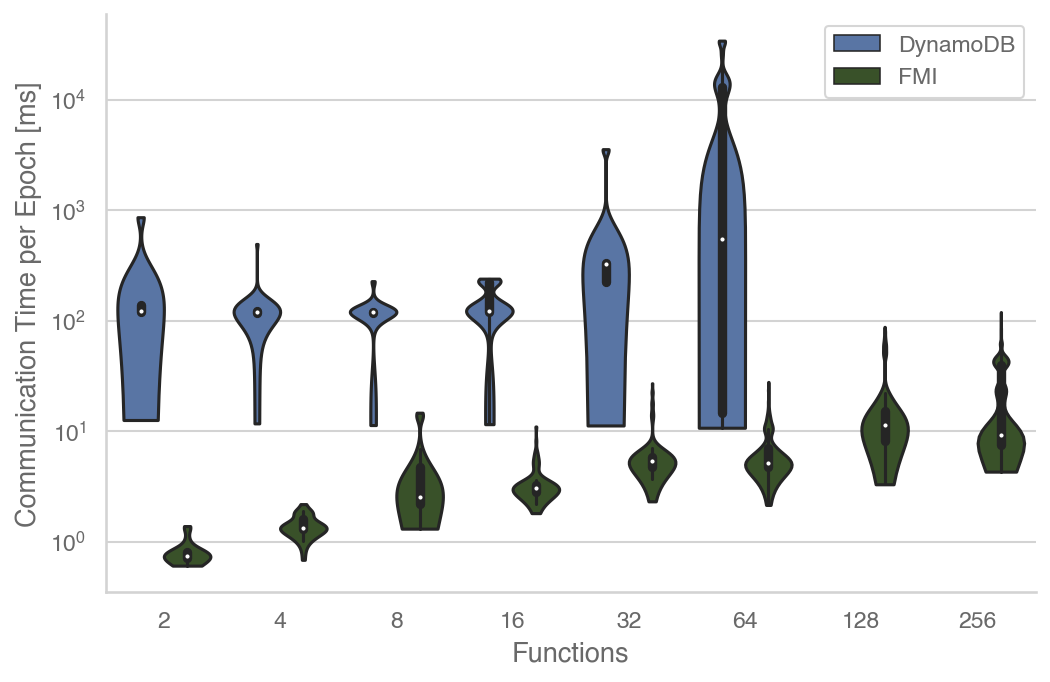

In [7]:
my_pal = {"DynamoDB": "b", "FMI": "#385723"}
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
ax.set_yscale('log')
sns.violinplot(x="n", y="latency", hue="method", data=vals, ax=ax, cut=0, palette=my_pal, scale="count")
ax.set_xlabel("Functions")
ax.set_ylabel("Communication Time per Epoch [ms]")
ax.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "fmi_benchmark_lambdaml.pdf"), bbox_inches='tight')

'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


{2: 0.008965061616195574, 4: 0.01196098604095777, 8: 0.023194766145745914, 16: 0.05316193065642251, 32: 0.35920268552055096, 64: 7.5264374851456015}
{2: 0.013427329888078902, 4: 0.013496359269041486, 8: 0.013956190596445402, 16: 0.014335585074093608, 32: 0.016823077753734587, 64: 0.020624279741369354}


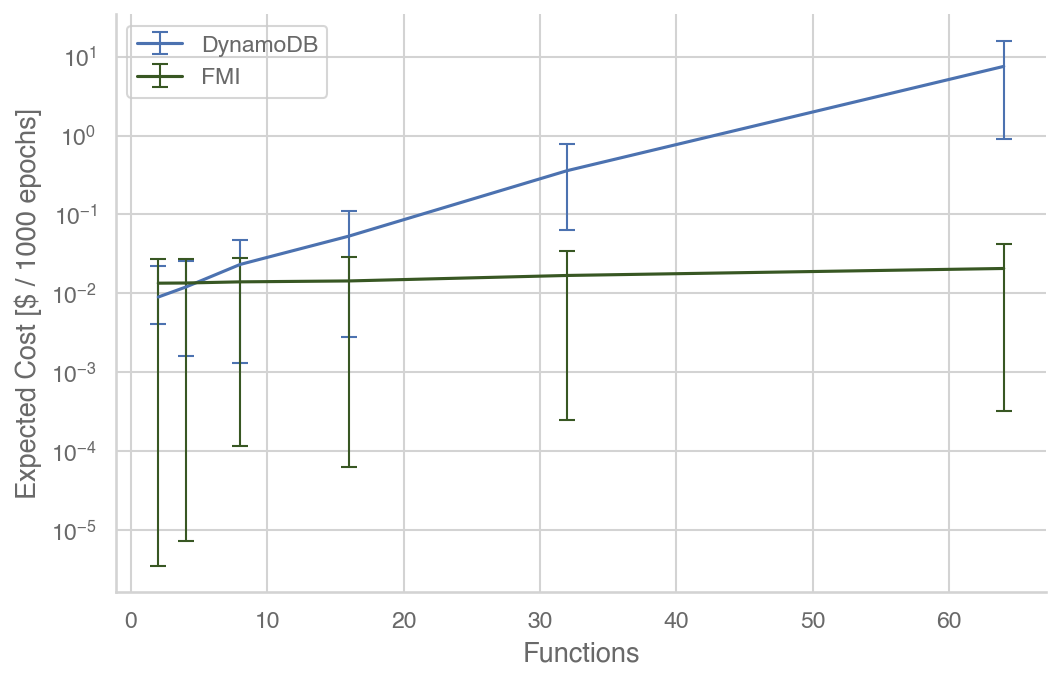

In [10]:
import scipy.stats as st
ec2_instance_price = 0.0134
gib_second_price = 0.0000166667
dynamodb_rcu_price = 0.0001586
dynamodb_wcu_price = 0.000793

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Functions")
ax.set_ylabel("Expected Cost [$ / 1000 epochs]")
#ax.set_xticks(list(one_to_many_scalability_means["S3"].keys()))
#ax.set_xticklabels(format_xticks(one_to_many_scalability_means["S3"].keys()))
ddb_lower_error, ddb_upper_error = [], []
ddb_plot_data = {}
smi_lower_error, smi_upper_error = [], []
smi_plot_data = {}
for num_node in NUM_NODES:
    if num_node > 64:
        continue

    dynamodb_data = vals[(vals['n'] == num_node) & (vals['method'] == "DynamoDB")]['latency']
    dynamodb_mean = np.mean(dynamodb_data)
    low, high = st.t.interval(0.95, len(dynamodb_data) - 1, loc=dynamodb_mean, scale=st.sem(dynamodb_data))
    ddb_fixed_cost = num_node * dynamodb_rcu_price + num_node * dynamodb_wcu_price
    ddb_price = dynamodb_mean * num_node * 1000 / 1000 * gib_second_price + ddb_fixed_cost
    low_price = low * num_node * 1000 / 1000 * gib_second_price + ddb_fixed_cost
    high_price = high * num_node * 1000 / 1000 * gib_second_price + ddb_fixed_cost
    ddb_plot_data[num_node] = ddb_price
    ddb_lower_error.append(low_price)
    ddb_upper_error.append(high_price)

    smi_data = vals[(vals['n'] == num_node) & (vals['method'] == "FMI")]['latency']
    smi_mean = np.mean(smi_data)
    low, high = st.t.interval(0.95, len(smi_data) - 1, loc=smi_mean, scale=st.sem(smi_data))
    smi_fixed_cost = ec2_instance_price
    smi_price = smi_mean * num_node * 1000 / 1000 * gib_second_price + smi_fixed_cost
    low_price = low * num_node * 1000 / 1000 * gib_second_price + smi_fixed_cost
    high_price = high * num_node * 1000 / 1000 * gib_second_price + smi_fixed_cost
    smi_plot_data[num_node] = smi_price
    smi_lower_error.append(low_price)
    smi_upper_error.append(high_price)
    
ax.errorbar(ddb_plot_data.keys(), ddb_plot_data.values(), [ddb_lower_error, ddb_upper_error], elinewidth=1, capsize=4, label="DynamoDB", color="b")
ax.errorbar(smi_plot_data.keys(), smi_plot_data.values(), [smi_lower_error, smi_upper_error], elinewidth=1, capsize=4, label="FMI", color="#385723")
print(ddb_plot_data)
print(smi_plot_data)
ax.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "fmi_benchmark_lambdaml_costs.pdf"), bbox_inches='tight')
plt.show()